# 02_tweet_analysis
For the RootCause/Corridor Labs collab, we want to do a range of analyses on the tweets we have collected.  
This notebook contains said analyses, ordered in chapters. The chapters are as follows: 
1. Qatar-related tweets: How has (simple) **sentiment** evolved over time and what can we learn from it?
2. **Tweets in general. Production of a descriptive overview of what the tweets we have collected contain, sorted by popularity/frequency.**
3. MERS tweets. Can we find any interesting patterns in world-cup-tangential tweets mentioning 'MERS'/'camel flu'?
4. General investigations into misinformation etc. Can we find origins and evolutions about the Saudi X Ray image? 

NL, 22/12/22  
NL, 23/12/22 -- re-jigging so as to not overcount retweets for non-original tweets

## IMPORTS

In [217]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

## PATHS & CONSTANTS

In [57]:
DATES = ['2022_11_26', '2022_12_04', '2022_12_14', '2022_12_18']

TWEETS_PATH = '/home/nikloynes/projects/world_cup_misinfo_tracking/data/tweets_clean/'
ENTITIES_PATH = '/home/nikloynes/projects/world_cup_misinfo_tracking/data/tweets_meta/'
EXPORT_PATH = '/home/nikloynes/projects/world_cup_misinfo_tracking/data/exports/tweets/'

## INIT

In [3]:
pio.renderers.default='notebook'

In [34]:
pd.set_option('display.max_rows', 100)

In [206]:
lemmatizer = WordNetLemmatizer()

## FUNCTIONS

In [208]:
def remove_pattern(input, pattern):
    out = re.sub(pattern, '', input)
    return out

def clean_tweets(tweets):
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:")
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    return tweets

In [238]:
def remove_stopwords(text:list):
    my_stopwords = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish') + stopwords.words('arabic')
    words = [w for w in text if w not in my_stopwords]
    return words

def word_lemmatizer(text:list):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

## THE THING!

### TWEETS
Now, in chapter 2, we shift our attention to the general analysis of *all* the tweets we've collected. 

1. Who are the top users - per chunk and in total? We will find this out by iterating over tweets; retrieving user ids and adding/appending their likes/RTs/replies
2. What are the most frequent entities -- and what are some unusual, and perhaps interesting entities? For this we're leveraging Twitter's self-supplied `entities` info, which we've saved for each file already.
3. What were the top pieces of content (tweets, URLs, domains, videos, images)

### USERS

In [4]:
tweet_files = os.listdir(TWEETS_PATH)
tweet_files.sort()

In [5]:
tweet_files.remove('tweets_2022_12_18-16_00_01-old_broken.json')

In [18]:
all_users = {}

**Extracting core user-level metrics from our samples of tweets**

Note: we are only counting retweets if a user was the original author of a tweet (or quote tweet). We are not counting retweets for a pure retweet, as this would count all instances of a retweet of the original tweet - not those of the particular instance of a given users' retweet.  

In [19]:
tweets = []
for file in tweet_files:
    target_date = file[7:17]
    with open(TWEETS_PATH+file, 'r') as infile:
        for line in tqdm(infile):
            tmp = json.loads(line)
            # all users
            if tmp['author_id'] not in all_users.keys():
                all_users[tmp['author_id']] = {'tweet_count' : 1}
                # make sure we only count retweets if we're looking at a
                # first-author tweet.
                if not ('referenced_tweets' in tmp.keys() and 'retweeted' in [x['type'] for x in tmp['referenced_tweets']]): 
                    all_users[tmp['author_id']]['retweet_count'] = tmp['public_metrics']['retweet_count']
                else:
                    all_users[tmp['author_id']]['retweet_count'] = 0
                all_users[tmp['author_id']]['reply_count'] = tmp['public_metrics']['reply_count'] 
                all_users[tmp['author_id']]['like_count'] = tmp['public_metrics']['like_count']
                all_users[tmp['author_id']]['quote_count'] = tmp['public_metrics']['quote_count']
                all_users[tmp['author_id']][f'in_{target_date}'] = True

                # user-metrics (these are no generic, not specific to our samples)
                all_users[tmp['author_id']]['user_name'] = tmp['user']['username']
                all_users[tmp['author_id']]['follower_count'] = tmp['user']['public_metrics']['followers_count']
                all_users[tmp['author_id']]['following_count'] = tmp['user']['public_metrics']['following_count']

            else:
                all_users[tmp['author_id']]['tweet_count'] += 1
                if not ('referenced_tweets' in tmp.keys() and 'retweeted' in [x['type'] for x in tmp['referenced_tweets']]): 
                    all_users[tmp['author_id']]['retweet_count'] += tmp['public_metrics']['retweet_count']
                all_users[tmp['author_id']]['reply_count'] += tmp['public_metrics']['reply_count'] 
                all_users[tmp['author_id']]['like_count'] += tmp['public_metrics']['like_count']
                all_users[tmp['author_id']]['quote_count'] += tmp['public_metrics']['quote_count']
                all_users[tmp['author_id']][f'in_{target_date}'] = True

2264it [00:00, 61270.62it/s]
25719it [00:00, 68098.35it/s]
43888it [00:00, 68367.54it/s]
50354it [00:00, 70169.70it/s]
55748it [00:00, 69864.92it/s]
61778it [00:00, 68370.39it/s]
11487it [00:00, 66994.23it/s]
13194it [00:00, 64540.25it/s]
86704it [00:01, 65349.47it/s]
81108it [00:01, 65007.17it/s]
47279it [00:00, 66038.47it/s]
22075it [00:00, 65516.20it/s]
99529it [00:01, 58802.86it/s]
92643it [00:01, 58211.41it/s]
60033it [00:01, 59871.78it/s]
87739it [00:01, 62054.16it/s]
85849it [00:01, 61047.43it/s]
62355it [00:01, 60230.19it/s]
41891it [00:00, 61215.26it/s]
499it [00:00, 60287.99it/s]
31523it [00:00, 67250.85it/s]
1966it [00:00, 63807.24it/s]
15931it [00:00, 64131.39it/s]
120887it [00:01, 63563.36it/s]
159345it [00:02, 63495.73it/s]
160985it [00:02, 64316.83it/s]
185044it [00:02, 62333.73it/s]
156847it [00:02, 62694.98it/s]
44726it [00:00, 63541.99it/s]
267369it [00:04, 62014.93it/s]
527141it [00:08, 61069.86it/s]
442495it [00:07, 60557.07it/s]
470338it [00:07, 61591.04it/s]
99150

##

**Top-level counts**

In [20]:
print(f'N unique users in total: {len(all_users)}')

N unique users in total: 1852731


In [25]:
for date in DATES:
    print(f"N users for chunk {date}: {len([all_users[x][f'in_{date}'] for x in all_users.keys() if f'in_{date}' in all_users[x].keys()])}")

N users for chunk 2022_11_26: 307116
N users for chunk 2022_12_04: 279883
N users for chunk 2022_12_14: 517309
N users for chunk 2022_12_18: 1044254


In [26]:
all_users_df = pd.DataFrame(all_users).transpose().reset_index().rename(columns={'index' : 'user_id'})

In [28]:
# recode NaNs in `in_{date}` as False
for date in DATES:
    all_users_df[f'in_{date}'] = all_users_df[f'in_{date}'].fillna(False)

In [ ]:
all_users_df['interaction_count'] = all_users_df['like_count'] + all_users_df['quote_count'] + all_users_df['reply_count'] + all_users_df['retweet_count']

In [46]:
# re-order our columns
all_users_df = all_users_df[[
    'user_id',
    'user_name',
    'follower_count',
    'following_count',
    'tweet_count',
    'retweet_count',
    'reply_count',
    'like_count', 
    'quote_count',
    'interaction_count',
    'in_2022_11_26',
    'in_2022_12_04',
    'in_2022_12_14',
    'in_2022_12_18'
    ]]

In [47]:
prolific_users_df = all_users_df.loc[
    (all_users_df['in_2022_11_26']==True) &
    (all_users_df['in_2022_12_04']==True) &
    (all_users_df['in_2022_12_14']==True) &
    (all_users_df['in_2022_12_18']==True)      
]

In [48]:
np.mean(all_users_df['retweet_count'])

1.5220061627942751

In [49]:
np.mean(all_users_df['like_count'])

11.532634796956494

In [50]:
np.mean(all_users_df['reply_count'])

0.38381070970367526

In [51]:
np.mean(all_users_df['interaction_count'])

13.601833185713414

**Some takeaways**:
- We have a total of `1,852,731` unique users in our sample; out of a total of `3,844,895` tweets.
- This means that the mean number of tweets per user is slightly above `2` per user; the median is `1`.
- There are a total of `10,101` users which appear in all 4 samples.
- It is apparent that there is quite a difference in the number of tweet interactions based on how tweets were collected. Because of some issues with the server hosting this entire project, I had to collect 2 of the tweet chunk samples after the fact (1-2 days) using the *search* rather than the *streaming* method. In the search method; where tweets had a while to gather attention, our interaction numbers are much higher as compared to the streaming method, where we write a tweet to disk within seconds of it being published. If we're interested in getting complete, post-hoc interaction numbers for all tweets; we can do this via the *get_tweets* endpoint on the API (by supplying chunks of tweet ids which we've recorded). As far as I'm aware we aren't restricted by the 1-week time limit for this, but obviously the 2-million monthly limit applies, so it would have to happen via a different Twitter account's API credentials if it has to occur soon, or in January via Nik's Twitter.    
- As noted above, we're only looking at retweets of original and quote tweets; not pure retweets. The mean number of retweets per tweet is approx `1.5` -- but this is likely distorted given the issue outlined above. 
- Our mean number of likes per user is approx `11.5`. 
- Our mean number of replies per users is approx `0.4`.
- The mean number of any interaction per user is approx `13`.

#### User 'League Tables'

We will now look at some core metrics of interest, and display tables reflecting the **Top 100** users ranked based on that metric. I will leave any interpretation of this to the reader.

1. Any interaction

In [53]:
all_users_df.sort_values('interaction_count', ascending=False).reset_index()[:100]

,index,user_id,user_name,follower_count,following_count,tweet_count,retweet_count,reply_count,like_count,quote_count,interaction_count,in_2022_11_26,in_2022_12_04,in_2022_12_14,in_2022_12_18
0,106793,138372303,FIFAWorldCup,11173420,608,103,354144,23897,1651635,28588,2058264,True,True,True,True
1,1073074,44196397,elonmusk,122510051,158,4,98734,58577,1607631,12781,1777723,False,False,False,True
2,296818,18091004,ESPNFC,6958316,614,23,132532,6493,866149,11062,1016236,True,True,True,True
3,329417,330262748,FabrizioRomano,12796954,2203,10,100601,6727,790135,9725,907188,False,True,False,True
4,1055790,44409004,shakira,53305430,234,1,147747,3095,566520,4160,721522,False,False,False,True
5,257908,1561123663,brfootball,5967973,1047,15,62934,2103,362142,3745,430924,True,True,True,True
6,356251,1138458175663988738,PopBase,467303,2086,22,52234,5237,259063,14082,330616,False,True,True,True
7,354605,627673190,ChampionsLeague,45779558,628,15,32200,3414,260351,2613,298578,False,True,True,True
8,1472143,266135518,KSI,8560920,922,2,14523,863,247019,254,262659,False,False,False,True
9,1710867,14123683,andy_murray,3563717,166,1,17417,1531,215725,950,235623,False,False,False,True


2. Retweets

In [54]:
all_users_df.sort_values('retweet_count', ascending=False).reset_index()[:100]

,index,user_id,user_name,follower_count,following_count,tweet_count,retweet_count,reply_count,like_count,quote_count,interaction_count,in_2022_11_26,in_2022_12_04,in_2022_12_14,in_2022_12_18
0,106793,138372303,FIFAWorldCup,11173420,608,103,354144,23897,1651635,28588,2058264,True,True,True,True
1,1055790,44409004,shakira,53305430,234,1,147747,3095,566520,4160,721522,False,False,False,True
2,296818,18091004,ESPNFC,6958316,614,23,132532,6493,866149,11062,1016236,True,True,True,True
3,329417,330262748,FabrizioRomano,12796954,2203,10,100601,6727,790135,9725,907188,False,True,False,True
4,1073074,44196397,elonmusk,122510051,158,4,98734,58577,1607631,12781,1777723,False,False,False,True
5,257908,1561123663,brfootball,5967973,1047,15,62934,2103,362142,3745,430924,True,True,True,True
6,356251,1138458175663988738,PopBase,467303,2086,22,52234,5237,259063,14082,330616,False,True,True,True
7,54114,119593082,FOXSoccer,1436531,1459,88,36021,1756,127730,3048,168555,True,True,True,True
8,354605,627673190,ChampionsLeague,45779558,628,15,32200,3414,260351,2613,298578,False,True,True,True
9,488317,2557521,espn,43696497,430,12,27658,1085,175593,2736,207072,False,True,False,True


3. Overall number of tweets posted

In [55]:
all_users_df.sort_values('tweet_count', ascending=False).reset_index()[:100]

,index,user_id,user_name,follower_count,following_count,tweet_count,retweet_count,reply_count,like_count,quote_count,interaction_count,in_2022_11_26,in_2022_12_04,in_2022_12_14,in_2022_12_18
0,16234,1489397690551386112,fifawc_ABEMA,177493,19,994,2384,66,8023,267,10740,True,True,True,True
1,648237,1183565334,lilo6y,53800,10141,924,3,5,55,0,63,False,False,True,True
2,649587,1375927867,98coolnola,37857,5310,905,11,6,15,0,32,False,False,True,True
3,14498,16946704,SBSSportau,55182,2018,804,129,51,780,11,971,True,True,True,True
4,307181,1258241001048739840,RishabhDeo11,1,2,662,0,13,5,0,18,False,True,False,False
5,164996,349270821,Lared1061,150813,259,659,43,17,571,1,632,True,True,True,True
6,439134,1563791149898338306,moanow1,4,3,641,0,3,20,0,23,False,True,False,True
7,418795,1373313620327559172,EspnAllGame,54,14,637,0,1,2,0,3,False,True,True,True
8,685694,1487425884378497027,Krishna78494082,9,14,578,0,1,1,0,2,False,False,True,True
9,711195,1439834791168282629,sahu_cseb,8,62,575,1,0,3,0,4,False,False,True,True


4. Follower count

In [56]:
all_users_df.sort_values('follower_count', ascending=False).reset_index()[:100]

,index,user_id,user_name,follower_count,following_count,tweet_count,retweet_count,reply_count,like_count,quote_count,interaction_count,in_2022_11_26,in_2022_12_04,in_2022_12_14,in_2022_12_18
0,1073074,44196397,elonmusk,122510051,158,4,98734,58577,1607631,12781,1777723,False,False,False,True
1,325228,10228272,YouTube,77936208,1195,8,5,18,212,2,237,False,True,True,False
2,1347020,428333,cnnbrk,64113175,122,1,111,153,829,15,1108,False,False,False,True
3,315959,759251,CNN,60721570,1092,5,1508,438,9702,119,11767,False,True,False,True
4,284253,807095,nytimes,54691282,863,27,1456,1031,9947,207,12641,True,True,True,True
5,1055790,44409004,shakira,53305430,234,1,147747,3095,566520,4160,721522,False,False,False,True
6,1427961,23083404,KingJames,52558947,184,1,1905,946,38838,1643,43332,False,False,False,True
7,498429,5402612,BBCBreaking,51504224,3,2,173,98,1257,39,1567,False,True,False,True
8,355405,14872237,realmadrid,45853490,65,7,1222,257,28774,125,30378,False,True,True,True
9,354605,627673190,ChampionsLeague,45779558,628,15,32200,3414,260351,2613,298578,False,True,True,True


### ENTITIES

OK - now, let's have a look at the Twitter-supplied entities. Luckily, we've already recorded aggregate figures for this while initially collecting the data, so we needn't iterate over all tweets again. 

We will start by looking at a similar league-table approach, but then select some potentially more *interesting* / *unexpected* entitity names, with the goal of then producing subsamples of tweets which were classified by Twitter as being part of those entities. This may provide an interesting base for further analysis.  

In [61]:
entities_files = os.listdir(ENTITIES_PATH)
entities_files.sort()

Let's build a massive dict of entities with counts and timestamps... 

In [101]:
entities_by_time_df = pd.DataFrame()
entities_total = {}

In [102]:
for file in entities_files:
    with open(ENTITIES_PATH+file, 'r') as infile:
        timestamp = pd.to_datetime(file[8:27].replace('-', ' ').replace('_', '-'))
        tmp = json.load(infile)
        
        # let's start with overall
        for k,v in tmp.items():
            if k not in entities_total.keys():
                entities_total[k] = v
            else:
                entities_total[k] += v

        # now the df
        tmp_df = pd.DataFrame([tmp]).transpose().reset_index().rename(columns={'index' : 'entity', 0 : 'freq'})
        tmp_df['timestamp'] = timestamp
        entities_by_time_df = pd.concat([entities_by_time_df, tmp_df], axis=0)

In [157]:
entities_by_time_df = entities_by_time_df.reset_index(drop=True)

In [104]:
# let's sort our dict
entities_total = dict(sorted(entities_total.items(), key=lambda x:x[1], reverse=True))

In [112]:
entities_total_df = pd.DataFrame([entities_total]).transpose().reset_index().rename(columns={'index' : 'entity', 0 : 'freq'})

**Top 100 entities for all tweets**

In [113]:
entities_total_df[:100]

,entity,freq
0,Unified Twitter Taxonomy,2400448
1,Business Taxonomy,2392712
2,Sports & Fitness Business,2327266
3,Soccer,2310412
4,Sports,2308731
5,Sports League,2291172
6,FIFA Men's World Cup,2287512
7,Sports events,2279540
8,Events,2278760
9,Events [Entity Service],2146606


There are a total of almost 20k entities in our sample of tweets. In these top 100 entities, the only ones that appear immediately interesting to me are: `Politics`, `Political Figures`, `Politician`. 

But, of course there must be some entities of interest here. How to find them? We'll build a regular expression (a method for searching strings for characters) with short versions of concepts we might find interesting. Then, we'll lower-case all the entities, and then we'll try and see if we can find any matches. 

In [124]:
pattern = re.compile('human|rights|social|justice|injustice|migrant|worker|right|authority|regime|criminal|crime|authoritarian|women|lgbt|gay|woman|activism|union')

In [ ]:
entities_total_df['match'] = False

for idx,row in tqdm(entities_total_df.iterrows()):
    if len(re.findall(pattern=pattern, string=row['entity'].lower()))>0:
        entities_total_df['match'][idx] = True

In [148]:
sum(entities_total_df['match'])

106

Interesting -- this methodology has returned a total of `106` potential entities of interest for us. Let's have a look at them. 

In [151]:
interesting_entities_df = entities_total_df.loc[entities_total_df['match']==True].reset_index()

In [154]:
interesting_entities_df[:100]

,index,entity,freq,match
0,77,Women's national soccer teams,31437,True
1,147,Social media,8817,True
2,299,Brighton & Hove Albion,2638,True
3,439,Rugby Union,1151,True
4,492,Men's national rugby union teams,956,True
5,620,FIFA Women's World Cup,643,True
6,692,2023 Women's World Cup,527,True
7,807,Crime drama,384,True
8,969,Women's tennis,255,True
9,1154,Razor Ramon Real Gay,175,True


Wow... there's truly not all that much here. 98% of this seems pretty benign on the whole...  

The question is -- is Twitter simply trying to prevent us from finding those tweets that capture what we were looking for with our search terms, or were there simply hardly pertinent tweets in our samples? Perhaps everything is captured in the `Politics` category? Perhaps we need to dig deeper into the overview data of the entities, but it's not particularly promising. 

I think the only pertinent one of these categories is `Social causes`, which we'll add to the list for a little further investigation.

In [173]:
pertinent_entities = ['Politics', 'Political figures', 'Politician', 'Social causes']

The way in which we will begin investigating this is by charting the frequency of tweets classified as belonging to these entities over time, in a similar fashion as we did in chapter 1. 

In [174]:
target_entities_df = entities_by_time_df.loc[entities_by_time_df['entity'].isin(pertinent_entities)].reset_index(drop=True)

In [175]:
target_entities_df['timestamp'] = pd.to_datetime(target_entities_df['timestamp'], format='%Y-%m-%d %H:%M:%S', utc=True, errors='coerce')

In [176]:
target_entities_df

,entity,freq,timestamp
0,Politician,593,2022-11-26 06:00:00+00:00
1,Politician,618,2022-11-26 07:00:00+00:00
2,Politician,531,2022-11-26 08:00:00+00:00
3,Politician,682,2022-11-26 09:00:00+00:00
4,Politician,718,2022-11-26 12:00:00+00:00
5,Politician,700,2022-12-04 18:00:00+00:00
6,Politician,501,2022-12-04 19:00:00+00:00
7,Politician,1249,2022-12-04 20:00:00+00:00
8,Politician,1117,2022-12-04 21:00:00+00:00
9,Politician,983,2022-12-04 22:00:00+00:00


In [185]:
dates = ['2022-11-26', '2022-12-04', '2022-12-14', '2022-12-18']

date_ranges = [
    ['2022-11-26 03:00', '2022-11-26 14:00'],
    ['2022-12-04 16:00', '2022-12-04 23:30'],
    ['2022-12-14 16:00', '2022-12-14 23:30'],
    ['2022-12-18 14:00', '2022-12-18 20:30']
]

colours = ['blue', 'purple', 'orange', 'green']

for date in date_ranges: 
    for i, entity in enumerate(pertinent_entities):
        subset_df = target_entities_df.query(f'timestamp.between("{date[0]}", "{date[1]}")')
        subset_df = subset_df.loc[target_entities_df['entity']==entity]

        fig = go.Figure()
        fig.add_scatter(name=entity, x=subset_df['timestamp'], y=subset_df['freq'], line=dict(color=colours[i], width=3.5))
        fig.update_traces(connectgaps=True)
        fig.update_layout(
            title=f'Frequency of tweets classified as entity {entity}, on {date[0][:10]}',
            xaxis_title='Tweet posted at',
            yaxis_title='Frequency',
            legend_title='Entity name'
        )
        fig.show()

I'll leave the interpretation of these graphs to the reader -- to me there doesn't appear to be all too much going on here. 

#### Analysing tweets which were classified to these entities

Let's now attempt to learn a little more about the tweets which have been classified by Twitter as one of these 4 entities. For this purpose, we'll again iterate over our tweet jsons, and then extract tweets which match these criteria. There shouldn't be too many, so we can pull all available tweet info into memory.

In [194]:
pertinent_tweets = []

for file in tqdm(tweet_files):
    with open(TWEETS_PATH+file, 'r') as infile:
        for line in infile:
            tmp = json.loads(line)
            if 'entities' in tmp.keys():
                if any(check in pertinent_entities for check in tmp['entities'].keys()):
                    pertinent_tweets.append(tmp)

100%|██████████| 36/36 [00:54<00:00,  1.53s/it]


In [195]:
len(pertinent_tweets)

67429

We've found a total of `67,429` tweets matching our inclusion criteria.

In [239]:
pertinent_text = list(pd.DataFrame(pertinent_tweets)['text'])

In [240]:
pertinent_text = clean_tweets(pertinent_text)

In [241]:
words = []

for tweet in pertinent_text:
    tmp = re.sub(r'[^\w\s]', '', tweet)
    words += tmp.split()

In [242]:
words = [x.lower() for x in words]

In [243]:
words = remove_stopwords(words)
words = word_lemmatizer(words)

**A wordcloud**

In [244]:
wordcloud = WordCloud().generate(' '.join(words))

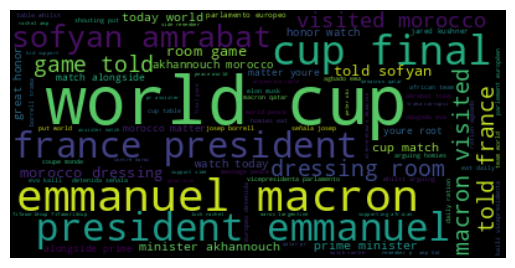

In [245]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**The word frequency table**

In [246]:
word_freqs = dict(zip(Counter(words).keys(), Counter(words).values()))
word_freqs = dict(sorted(word_freqs.items(), key=lambda x:x[1], reverse=True))

In [247]:
word_freqs_df = pd.DataFrame.from_dict(word_freqs.items()).reset_index(drop=True)[:100]
word_freqs_df = word_freqs_df.rename(columns={0 : 'word', 1 : 'freq'})

This is frustrating... clearly it hasn't properly removed stopwords... 

In [248]:
word_freqs_df

,word,freq
0,qatar,21193
1,world,17213
2,cup,14755
3,macron,10923
4,fifaworldcup,8924
5,final,6936
6,france,6789
7,morocco,6399
8,president,6135
9,told,6107


#### EXPORTS

In [ ]:
# all_users_df
# prolific_users_df
# entities_total_df
# entities_by_time_df
# pertinent_words_frequencies.csv